In [16]:
import numpy as np
from matplotlib import image
from matplotlib import pyplot
import ast
import glob
import pandas as pd
from tqdm import tqdm

float32
(1080, 1920, 4)


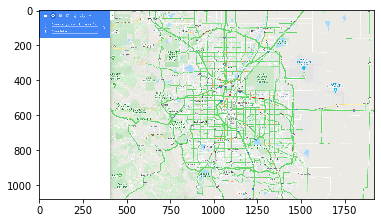

In [17]:
#load in image as pixel array
traffic_im1 = image.imread('../../data/input/denvertraffic2020-04-30 12_45_46.png')
print(traffic_im1.dtype)
print(traffic_im1.shape)
pyplot.imshow(traffic_im1)
pyplot.show()

 The screenshots have the google maps tab on the left edge. It looks like the slicing the images at all rows, cols 420 to 1720, and all depths, gives an image centered on the metro with no side panel or extra eastern plains. I promise you I did not consciously do that. It just works for Denver, you know :)

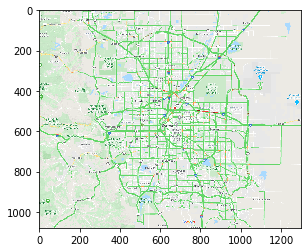

In [18]:
pyplot.imshow(traffic_im1[:,420:1720,:])
pyplot.show()

With an extent specified, we can use that to clip the images to the desired area. trim_image_xy 

In [19]:
def trim_image_xy(image_path, top=0, bottom=0, left=0, right=0):
    """trim an image at specified path by rows on left and right edgeand columns on top and bottom"""
    #read in image
    im1 = image.imread(image_path)

    #capture shape of numpy array
    rows, cols, depth = im1.shape


    #trim image and store result in image_clip
    image_clip = im1[(top):(rows - bottom), (left):(cols - right), :]

    return image_clip

In [20]:
im_clipped = trim_image_xy('../../data/input/denvertraffic2020-04-30 12_45_46.png', left= 420, right = 200)

In [21]:
im_clipped

array([[[0.78039217, 0.89411765, 0.7764706 , 1.        ],
        [0.7764706 , 0.89411765, 0.77254903, 1.        ],
        [0.76862746, 0.88235295, 0.7647059 , 1.        ],
        ...,
        [0.9254902 , 0.91764706, 0.89411765, 1.        ],
        [0.9254902 , 0.91764706, 0.89411765, 1.        ],
        [0.9254902 , 0.91764706, 0.89411765, 1.        ]],

       [[0.7607843 , 0.87058824, 0.75686276, 1.        ],
        [0.7411765 , 0.8509804 , 0.7411765 , 1.        ],
        [0.7607843 , 0.8745098 , 0.75686276, 1.        ],
        ...,
        [0.9254902 , 0.91764706, 0.89411765, 1.        ],
        [0.9254902 , 0.91764706, 0.89411765, 1.        ],
        [0.9254902 , 0.91764706, 0.89411765, 1.        ]],

       [[0.72156864, 0.827451  , 0.7176471 , 1.        ],
        [0.7254902 , 0.83137256, 0.72156864, 1.        ],
        [0.7411765 , 0.8509804 , 0.7411765 , 1.        ],
        ...,
        [0.9254902 , 0.91764706, 0.89411765, 1.        ],
        [0.9254902 , 0.917647

In [22]:
#read in text file of pixel labels and store as dictionary
with open('../../data/input/color_labels.txt', 'r') as inf:

    #skip first line that has a title
    next(inf)

    #store text file dictionary in pixel_labels
    pixel_labels = ast.literal_eval(inf.read())

In [23]:
def count_dict_pixels(label_dict, image_array, alpha=255):
    """takes in a dictionary of tuples with values as pixel values,
    labels as keys, and counts the images in a pixel that meet each key"""
    if image_array.dtype == 'float32':

        #create dictionary for pixel counts by key
        output_dict = {}

        #convert values from 0-1 space to 0-255 space
        image_array = image_array * 255

        for key, value in label_dict.items():
            r, g, b = value

            #red channel
            ar_temp_r = np.zeros(image_array[:, :, 0].shape)
            r_true = np.where(image_array[:, :, 0] == r)
            ar_temp_r[r_true] = 1

            #green channel
            ar_temp_g = np.zeros(image_array[:, :, 1].shape)
            g_true = np.where(image_array[:, :, 1] == g)
            ar_temp_g[g_true] = 1

            #blue channel
            ar_temp_b = np.zeros(image_array[:, :, 2].shape)
            b_true = np.where(image_array[:, :, 2] == b)
            ar_temp_b[b_true] = 1

            #alpha channel
            ar_temp_alpha = np.zeros(image_array[:, :, 2].shape)
            alpha_true = np.where(image_array[:, :, 3] == alpha)
            ar_temp_alpha[alpha_true] = 1

            #multiplying results in binary matrix where rgba = the specified value tuple
            mask_array = ar_temp_r * ar_temp_g * ar_temp_b * ar_temp_alpha

            #sum results in number of pixels matching rgba value
            pixel_count = mask_array.sum()
            
            #update output dict with pixel count
            output_dict[key] = pixel_count

    else:
        print(
            'image array dtype is not float32 or float64 (values ranging from 0-1). Consider converting using .astype(np.float32)'
        )
    return output_dict

In [24]:
test_image_pixel_counts = count_dict_pixels(pixel_labels, im_clipped, alpha = 255)
test_image_pixel_counts

{'traffic_green': 110471.0,
 'traffic_crimson': 137.0,
 'traffic_bright_red': 296.0,
 'traffic_orange': 2882.0,
 'traffic_peach': 793.0,
 'traffic_peach_orange': 844.0,
 'basemap_road_no_traffic_data': 48506.0,
 'basemap_road_edge': 3841.0,
 'traffic_closure': 128.0,
 'basemap_closed_place_marker': 455.0,
 'basemap_airport_marker': 485.0,
 'basemap_airport_label': 218.0,
 'basemap_water': 13322.0,
 'basemap_park': 59522.0,
 'basemap_city_space': 255534.0,
 'basemap_park_label_text': 1799.0,
 'basemap_beach_sand': 769.0,
 'google_label_blue': 64.0,
 'google_label_red': 34.0,
 'google_label_yellow': 18.0,
 'google_label_green': 13.0,
 'basemap_interstate_marker_blue': 1483.0,
 'basemap_interstate_marker_red': 434.0,
 'basemap_city_name_label': 1467.0,
 'basemap_major_road_center': 1297.0,
 'basemap_major_road_edge': 410.0}

Now that the testing is done, I will loop through all the images and process them in this way. For the index, i will use the timestamp from the filename and each row will have the labels as columns and the count of pixels as values.

In [25]:
 glob.glob("C:\\Users\\Stuart\\Downloads\\trafficimages\\*.png")

['C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic2020-04-29 16_33_03.png',
 'C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic2020-04-29 16_45_41.png',
 'C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic2020-04-29 17_01_40.png',
 'C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic2020-04-29 17_15_48.png',
 'C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic2020-04-29 17_30_53.png',
 'C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic2020-04-29 17_45_38.png',
 'C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic2020-04-29 18_01_41.png',
 'C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic2020-04-29 18_15_51.png',
 'C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic2020-04-29 18_30_51.png',
 'C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic2020-04-29 18_45_40.png',
 'C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic2020-04-29 19_01_22.png',
 'C:\\Users\\Stuart\\Downloads\\trafficimages\\denvert

In [31]:
image_list = glob.glob("C:\\Users\\Stuart\\Downloads\\trafficimages\\*.png")
image_times = [x.replace('C:\\Users\\Stuart\\Downloads\\trafficimages\\denvertraffic', '') for x in image_list]
image_times = [x.replace('.png', '') for x in image_times]
image_times = [x.replace('_', ':') for x in image_times]

frame_dict = {}

for position, file in enumerate(tqdm(image_list)):
    im_trim = trim_image_xy(file, left= 420, right = 200)
    frame_dict[image_times[position]] = count_dict_pixels(pixel_labels, im_trim)


100%|██████████| 445/445 [22:52<00:00,  3.09s/it]


In [1]:
time_series = pd.DataFrame.from_dict(frame_dict, orient= 'index')
time_series.index =pd.to_datetime(time_series.index)

NameError: name 'pd' is not defined

In [34]:
time_series.to_csv('../../data/output/test_series1.csv', index=True)

In [36]:
time_series.columns.tolist()

['traffic_green',
 'traffic_crimson',
 'traffic_bright_red',
 'traffic_orange',
 'traffic_peach',
 'traffic_peach_orange',
 'basemap_road_no_traffic_data',
 'basemap_road_edge',
 'traffic_closure',
 'basemap_closed_place_marker',
 'basemap_airport_marker',
 'basemap_airport_label',
 'basemap_water',
 'basemap_park',
 'basemap_city_space',
 'basemap_park_label_text',
 'basemap_beach_sand',
 'google_label_blue',
 'google_label_red',
 'google_label_yellow',
 'google_label_green',
 'basemap_interstate_marker_blue',
 'basemap_interstate_marker_red',
 'basemap_city_name_label',
 'basemap_major_road_center',
 'basemap_major_road_edge']

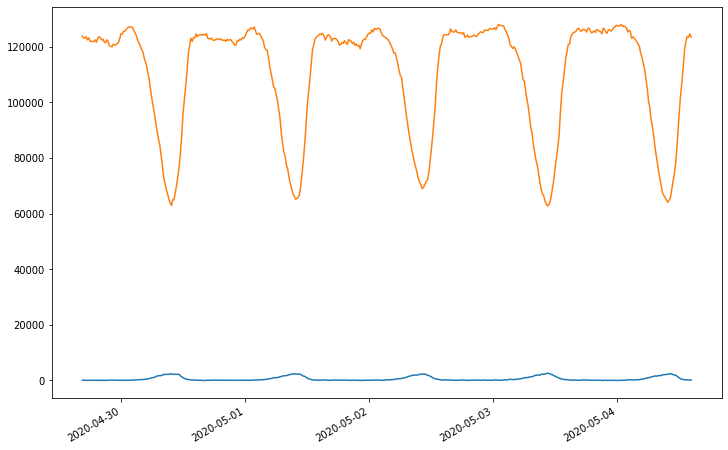

In [60]:
time_series.plot(y=['basemap_major_road_edge', 'traffic_green'], kind='line', use_index=True, legend=None,
                 figsize= (12,8))